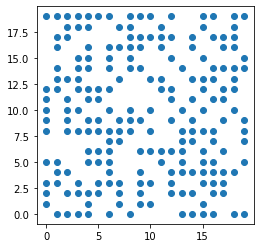

In [40]:
import matplotlib.pyplot as plt
        
def plot_lattice(lat_list):
    # the input list is m-by-n. A 0 indicates no atom, and a 1 indicates the lattice point is occupied.
    dim1 = len(lat_list)
    dim2 = len(lat_list[0])
    x_list = []
    y_list = []
    for i in range(dim1):
        for j in range(dim2):
            if lat_list[i][j] == 1:
                x_list.append(j)
                y_list.append(i)
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.scatter(x_list, y_list)
    ax.set_aspect('equal')
    plt.axis('square')

In [58]:
# this cell contains some basic functions
import random
import numpy as np
from copy import deepcopy

## note that the coordinates in the movement list is ordered as (x,y)
## on the other hand, by the convention in progrmming, the coordinates in the lattice list is orderes as (y, x)

def fill_atoms(x_dim, y_dim, filling_ratio):
    # generate a 2D list with atom at some locations (entry = 1), 
    # and the number of atoms is determined by the filling_ratio
    lat_list = [0] * (x_dim * y_dim)
    for i in range(x_dim * y_dim):
        r = random.random()
        if r < filling_ratio:
            lat_list[i] = 1
    lat_list = np.array(lat_list).reshape(y_dim,x_dim) # note that the lat_list being returned is an np array
    return lat_list#.tolist()

def check_num_of_atom(lat_list, required_atom_num):
    # check whether the number of trapped atoms is greater than or equal to the number of required atoms
    num_atom = sum(sum(lat_list,[]))
    if num_atom > required_atom_num:
        return True # the number of atom in the lattice is enough to be arranged into the desired geometry
    else:
        return False

def shift_down(upper_row, lower_row, upper_row_idx, lower_row_idx):
    # shift the atoms from the upper row vertically to the lower one if the corresponding lower slot is empty
    # if the layout looks like:  00xxx0x000x0
    #                            x000x0xxx0xx
    # then the resulting layout after executing the function will become:
    #                            x0xxx0xxx0xx
    #                            0000x0x000x0
    # this function returns a list of movement steps so that external operations may modify the array accordingly
    x_dim = len(upper_row)
    #print(x_dim)
    downward_shift_list = []
    for i in range(x_dim): # note that 0: empty, 1: atom
        if upper_row[i] == 1 and lower_row[i] == 0: # shift downward
            downward_shift_list.append(i)
    #print(downward_shift_list)
    init_coor_list  = []
    final_coor_list = []
    for i in range(len(downward_shift_list)): # construct the return list
        init_coor_list.append((downward_shift_list[i], upper_row_idx))
        final_coor_list.append((downward_shift_list[i], lower_row_idx))
    return [init_coor_list, final_coor_list]

def shift_up(upper_row, lower_row, upper_row_idx, lower_row_idx):
    # same idea as shift down
    # this function returns a list of movement steps so that external operations may modify the array accordingly
    x_dim = len(upper_row)
    upward_shift_list = []
    for i in range(x_dim): # note that 0: empty, 1: atom
        if lower_row[i] == 1 and upper_row[i] == 0: # shift upward
            upward_shift_list.append(i)
    
    init_coor_list  = []
    final_coor_list = []
    for i in range(len(upward_shift_list)): # construct the return list
        init_coor_list.append((upward_shift_list[i], lower_row_idx))
        final_coor_list.append((upward_shift_list[i], upper_row_idx))
    return [init_coor_list, final_coor_list]

def move_temp_list(temp_list, movement):
    # the function modifies temp_list according to the moves specified in movement
    for p1, p2 in zip(movement[0], movement[1]):
        # determine whether the movement is horizontal or vertical
        if p1[0] == p2[0]: # the move is vertical
            x_coor = p1[0]
            temp_list[p1[1]][x_coor] = 0
            temp_list[p2[1]][x_coor] = 1
        elif p1[1] == p2[1]: # the move is horizontal
            y_coor = p1[1]
            temp_list[y_coor][p1[0]] = 0
            temp_list[y_coor][p2[0]] = 1
        
def shift_one_down(upper_row, lower_row, upper_row_idx, lower_row_idx):
    # shift one atom from the upper row to the lower row
    # return a movement list
    init_coor_list  = []
    final_coor_list = []
    for index, (u_point, l_point) in enumerate(zip(upper_row, lower_row)):
        if u_point == 1 and l_point == 0:
            init_coor_list.append((index, upper_row_idx))
            final_coor_list.append((index, lower_row_idx))
            break
    return [init_coor_list, final_coor_list]

def shift_one_up(upper_row, lower_row, upper_row_idx, lower_row_idx):
    # shift one atom from the lower row to the upper row
    # return a movement list
    init_coor_list  = []
    final_coor_list = []
    for index, (u_point, l_point) in enumerate(zip(upper_row, lower_row)):
        if u_point == 0 and l_point == 1:
            init_coor_list.append((index, lower_row_idx))
            final_coor_list.append((index, upper_row_idx))
            break
    return [init_coor_list, final_coor_list]

def form_core_movement(init_positions, final_positions, y_idx):
    # return a movement step (for a row) to form the core atom array
    init_coor_list  = []
    final_coor_list = []
    for i_pos, f_pos in zip(init_positions, final_positions):
        init_coor_list.append((i_pos, y_idx))
        final_coor_list.append((f_pos, y_idx))
    return [init_coor_list, final_coor_list]

def concentrate_to_center(temp_lat_list, y_coor):
    x_dim = len(temp_lat_list[0])
    # record the initial positions of the atoms
    init_positions = [j for j,x in enumerate(temp_lat_list[y_coor]) if x==1]

    ### fill the atom to the center
    num_atom = sum(temp_lat_list[y_coor])
    if num_atom == 0:
        return False
    start_pos = (x_dim - num_atom)//2
    temp_lat_list[y_coor] = [0] * x_dim
    temp_lat_list[y_coor][start_pos:start_pos+num_atom] = [1] * num_atom
    final_positions = [j for j,x in enumerate(temp_lat_list[y_coor]) if x==1]
    movement = form_core_movement(init_positions, final_positions, y_coor)
    return movement

def shift_to_sides(temp_lat_list, y_coor):
    x_dim = len(temp_lat_list[0])
    # record the initial positions of the atoms
    init_positions = [j for j,x in enumerate(temp_lat_list[y_coor]) if x==1]

    ### fill the atom to the center
    num_atom = sum(temp_lat_list[y_coor])
    if num_atom == 0:
        return False
    start_pos = (x_dim - num_atom)//2
    temp_lat_list[y_coor] = [0] * x_dim
    temp_lat_list[y_coor][0:num_atom//2] = [1] * (num_atom//2)
    rest_num = num_atom - (num_atom//2)
    temp_lat_list[y_coor][-rest_num:] = [1] * (rest_num)
    final_positions = [j for j,x in enumerate(temp_lat_list[y_coor]) if x==1]
    movement = form_core_movement(init_positions, final_positions, y_coor)
    return movement

def pre_sorting_shift_down(temp_lat_list, y_coor):
    return_list = []
    # move the atoms in the target row to the center
    movement = concentrate_to_center(temp_lat_list, y_coor+1)
    if movement != False:
        return_list.append(movement)
    # move the atoms in the moving row to both sides
    momvement = shift_to_sides(temp_lat_list, y_coor)
    if movement != False:
        return_list.append(movement)
    
    movement = shift_down(temp_lat_list[y_coor], temp_lat_list[y_coor+1], y_coor, y_coor+1)
    return_list.append(movement)
    # move the temp_lat_list to reflect the change
    move_temp_list(temp_lat_list, movement)
    return return_list

def pre_sorting_shift_up(temp_lat_list, y_coor):
    return_list = []
    # move the atoms in the target row to the center
    movement = concentrate_to_center(temp_lat_list, y_coor-1)
    if movement != False:
        return_list.append(movement)
    # move the atoms in the moving row to both sides
    momvement = shift_to_sides(temp_lat_list, y_coor)
    if movement != False:
        return_list.append(movement)
    
    movement = shift_up(temp_lat_list[y_coor-1], temp_lat_list[y_coor], y_coor-1, y_coor)
    return_list.append(movement)
    # move the temp_lat_list to reflect the change
    move_temp_list(temp_lat_list, movement)
    return return_list

def pre_sorting(lat_list, x_core_dim, y_core_dim):
    # ensure that each row has enough atoms (move the atom row-by-row in the next step)
    # core_dim denotes the dimension of the actual array to operate on
    # the core array will be placed around the center of the whole lattice
    # Returns a list containing the moving steps (movement_return_list)
    # and an array after the movements (temp_lat_list)
    # whereas the original input list of lattice (lat_list) is left intact
    
    # do the operation on the copied lattice and leave the original one intact
    temp_lat_list = deepcopy(lat_list)
    
    # dimension of the whole lattice
    y_dim = len(lat_list)
    x_dim = len(lat_list[0])
    
    # the list that contains the movements to be returned
    movement_return_list = []
    
    # determine the location of the core array
    x_start_coor = (x_dim - x_core_dim) // 2
    x_end_coor   = x_start_coor + x_core_dim
    y_start_coor = (y_dim - y_core_dim) // 2
    y_end_coor   = y_start_coor + y_core_dim
#     print(x_start_coor,x_end_coor,y_start_coor,y_end_coor)
    
    # use shift_up/down to accumulate as many atoms at the first and last row of the core array
    # shift down
#     for i in range(y_start_coor):
    for i in range(y_dim//2):
        move_list = pre_sorting_shift_down(temp_lat_list, i)
        movement_return_list.append(move_list)
    #shift up
#     for i in range(y_dim-1, y_end_coor-1, -1): # range(start, stop, step)    
    for i in range(y_dim-1, y_dim//2, -1):
        move_list = pre_sorting_shift_up(temp_lat_list, i)
        movement_return_list.append(move_list)
#     print(temp_lat_list)
    
    round_to_fail = 100 # if the while loop executes over this number of iterations, then break
    counter = 0 # count the number of loop executions
    while True:
        counter = counter + 1
        # check that each row in the desired range contains enough atoms
        flag = False
        for i in range(y_start_coor, y_end_coor): # iterate through all the core rows
            if (sum(temp_lat_list[i]) >= x_core_dim):
                flag = True
            else:
                flag = False
                break
        if flag == True or counter > round_to_fail:
            break 
        # accumulate atoms to the first and last core row every 10 iterations
        if (counter % 10) == 0:
            # shift down
            for i in range(y_start_coor):
                move_list = pre_sorting_shift_down(temp_lat_list, i)
                movement_return_list.append(move_list)
            #shift up
            for i in range(y_dim-1, y_end_coor-1, -1): # range(start, stop, step)
                move_list = pre_sorting_shift_up(temp_lat_list, i)
                movement_return_list.append(move_list)
        
        # determine which adjacent row should provide the atom needed
        for i in range(y_start_coor, y_end_coor): # iterate through all the core rows
            num_above  = sum(temp_lat_list[i-1])
            num_target = sum(temp_lat_list[i])
            num_below  = sum(temp_lat_list[i+1])
            if num_target >= num_above and num_target >= num_below: # the target row has the most atoms
                continue
            elif num_above > num_target and num_above >= num_below: # the row above has the most atoms
                # move one atom from the upper row to the target row
                movement = shift_one_down(temp_lat_list[i-1], temp_lat_list[i], i-1, i)
                movement_return_list.append(movement)
                move_temp_list(temp_lat_list, movement)
            elif num_below > num_target and num_below >= num_above: # the row below has the most atoms
                # move one atom from the lower row to the target row
                movement = shift_one_up(temp_lat_list[i], temp_lat_list[i+1], i, i+1)
                movement_return_list.append(movement)
                move_temp_list(temp_lat_list, movement)
#     print(counter)
    if counter > round_to_fail:
        if_fail = True
    else:
        if_fail = False
    return movement_return_list, temp_lat_list, if_fail, counter

def form_core_array(lat_list, x_core_dim, y_core_dim):
    # after pre-sorting, move the atoms row-by-row such that the desired atom array is positioned in the center
    # lat_list is the lattice list after presorting
    # core_dim denotes the dimension of the actual array to operate on
    # the core array will be placed around the center of the whole lattice
    # Returns a list containing the moving steps (movement_return_list)
    # and an array after the movements (temp_lat_list)
    # whereas the original input list of lattice (lat_list) is left intact
    
    # do the operation on the copied lattice and leave the original one intact
    temp_lat_list = deepcopy(lat_list)
    
    # dimension of the whole lattice
    y_dim = len(lat_list)
    x_dim = len(lat_list[0])
    
    # the list that contains the movements to be returned
    movement_return_list = []
    
    # determine the location of the core array
    x_start_coor = (x_dim - x_core_dim) // 2
    x_end_coor   = x_start_coor + x_core_dim
    y_start_coor = (y_dim - y_core_dim) // 2
    y_end_coor   = y_start_coor + y_core_dim
#     print(x_start_coor,x_end_coor,y_start_coor,y_end_coor)
    
    for i in range(y_start_coor, y_end_coor): # iterate through all the core rows
        # record the initial positions of the atoms
        init_positions = [j for j,x in enumerate(temp_lat_list[i]) if x==1]
        positions = deepcopy(init_positions)
            
        ### fill the atom to the center
        num_atom = sum(temp_lat_list[i])
        start_pos = (x_dim - num_atom)//2
        temp_lat_list[i] = [0] * x_dim
        temp_lat_list[i][start_pos:start_pos+num_atom] = [1] * num_atom
        final_positions = [j for j,x in enumerate(temp_lat_list[i]) if x==1]
        movement = form_core_movement(init_positions, final_positions, i)
        movement_return_list.append(movement)
    return movement_return_list, temp_lat_list
        



In [ ]:
a = fill_atoms(20, 20, 0.5)
temp_a = deepcopy(a)
core_x_dim = 10
core_y_dim = 10
movement_return_list_pre, temp_lat_list, if_fail, counter = pre_sorting(a, core_x_dim, core_y_dim)
movement_return_list_core, final_lat_list = form_core_array(temp_lat_list, core_x_dim, core_y_dim)
total_movement_list = movement_return_list_pre + movement_return_list_core

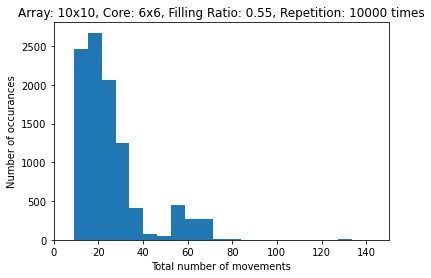

In [87]:
# investigate the distribution of number of movement steps with different array sizes and filling ratio

num_iter_arr = []  #count the number of success
core_dim = 6
for i in range(10000):
    a = fill_atoms(10, 10, 0.55)
    movement_return_list_pre, temp_lat_list, if_fail, counter = pre_sorting(a, core_dim, core_dim)
    num_iter_arr.append(len(movement_return_list_pre))

import matplotlib.pyplot as plt
plt.hist(num_iter_arr, bins=100)
plt.title('Array: 10x10, Core: 6x6, Filling Ratio: 0.55, Repetition: 10000 times')
plt.xlabel('Total number of movements')
plt.ylabel('Number of occurances')
plt.xlim(0,150)
plt.show()